# Time Series Clustering using Pretrained Models

This notebook demonstrates clustering of time series data using pretrained models and feature extraction techniques.

## Overview
- Time series clustering groups similar temporal patterns
- Uses feature extraction from pretrained models
- Applies traditional clustering algorithms on extracted features
- Evaluates clustering quality


In [2]:
# Install required packages (uncomment if needed)
!pip install tslearn tsfresh scikit-learn matplotlib seaborn numpy pandas

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 7.1 MB/s eta 0:00:00


## Generate Synthetic Time Series Data


Time series shape: (100, 100)
Number of clusters: 3


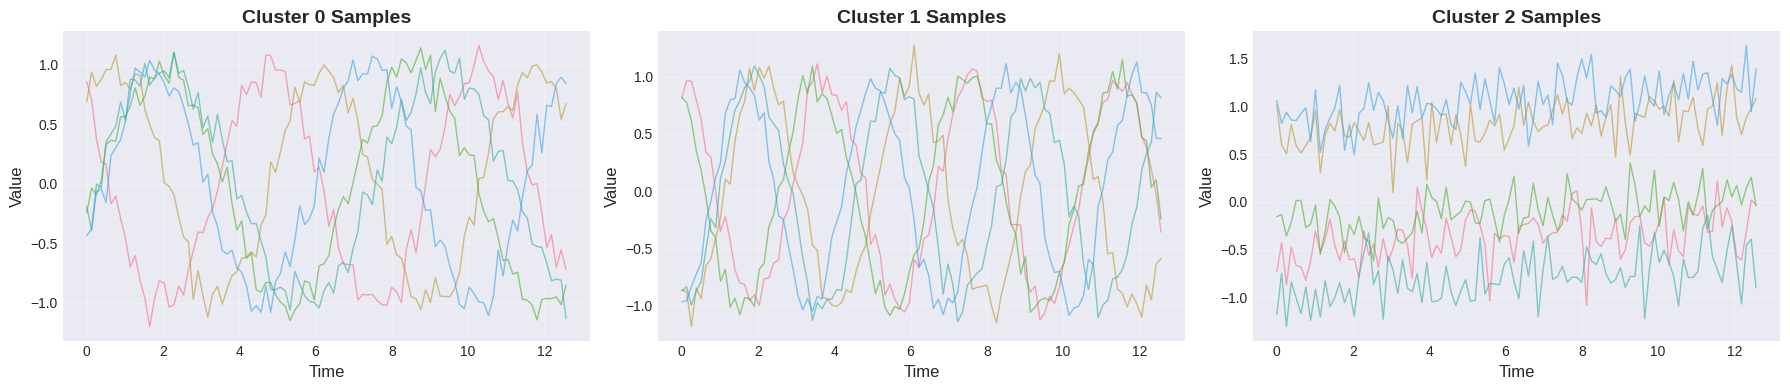

In [3]:
# Generate synthetic time series data with different patterns
np.random.seed(42)
n_samples = 100
n_timesteps = 100
n_clusters = 3

time = np.linspace(0, 4*np.pi, n_timesteps)
time_series_data = []
true_labels = []

# Cluster 1: Sine waves
for i in range(n_samples // 3):
    freq = np.random.uniform(0.8, 1.2)
    phase = np.random.uniform(0, 2*np.pi)
    noise = np.random.normal(0, 0.1, n_timesteps)
    ts = np.sin(freq * time + phase) + noise
    time_series_data.append(ts)
    true_labels.append(0)

# Cluster 2: Cosine waves with different frequency
for i in range(n_samples // 3):
    freq = np.random.uniform(1.5, 2.0)
    phase = np.random.uniform(0, 2*np.pi)
    noise = np.random.normal(0, 0.1, n_timesteps)
    ts = np.cos(freq * time + phase) + noise
    time_series_data.append(ts)
    true_labels.append(1)

# Cluster 3: Linear trend with noise
for i in range(n_samples - 2*(n_samples // 3)):
    slope = np.random.uniform(0.01, 0.05)
    intercept = np.random.uniform(-1, 1)
    noise = np.random.normal(0, 0.2, n_timesteps)
    ts = slope * time + intercept + noise
    time_series_data.append(ts)
    true_labels.append(2)

X_ts = np.array(time_series_data)
y_true = np.array(true_labels)

# Shuffle
shuffle_idx = np.random.permutation(len(X_ts))
X_ts = X_ts[shuffle_idx]
y_true = y_true[shuffle_idx]

print(f"Time series shape: {X_ts.shape}")
print(f"Number of clusters: {len(np.unique(y_true))}")

# Visualize sample time series from each cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for cluster_id in range(3):
    cluster_samples = X_ts[y_true == cluster_id][:5]
    for ts in cluster_samples:
        axes[cluster_id].plot(time, ts, alpha=0.6, linewidth=1)
    axes[cluster_id].set_title(f'Cluster {cluster_id} Samples', fontsize=14, fontweight='bold')
    axes[cluster_id].set_xlabel('Time', fontsize=12)
    axes[cluster_id].set_ylabel('Value', fontsize=12)
    axes[cluster_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Method 1: Feature Extraction + K-Means


FEATURE EXTRACTION + K-MEANS RESULTS
Silhouette Score: 0.6145
Adjusted Rand Index: 0.4406
Davies-Bouldin Index: 0.7163


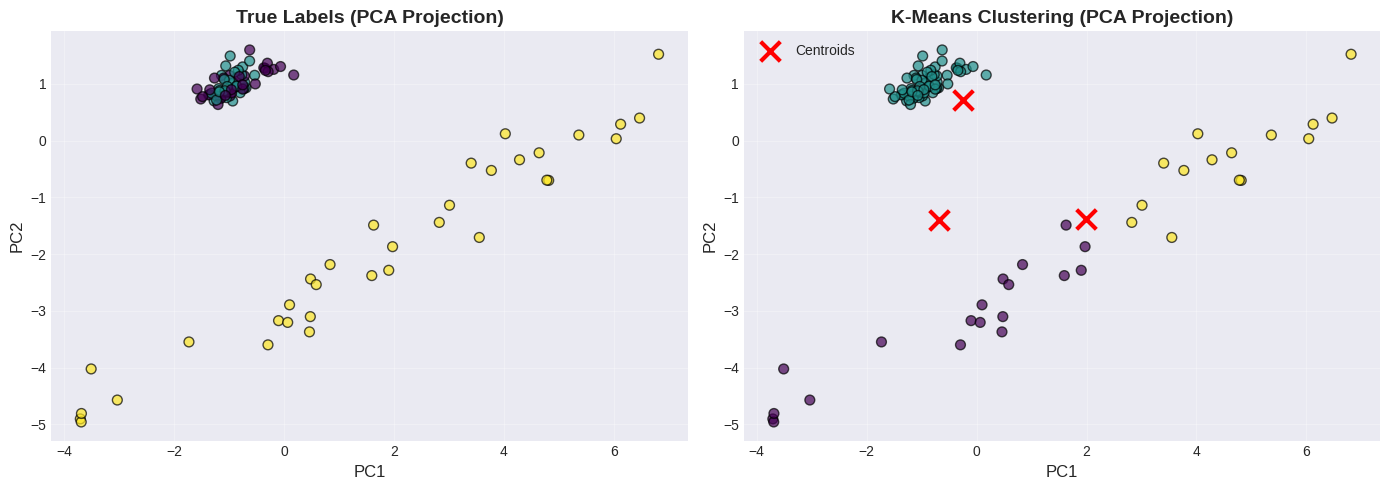

In [4]:
# Extract statistical features from time series
def extract_features(ts_data):
    features = []
    for ts in ts_data:
        feat = [
            np.mean(ts),
            np.std(ts),
            np.min(ts),
            np.max(ts),
            np.median(ts),
            np.percentile(ts, 25),
            np.percentile(ts, 75),
            np.sum(np.diff(ts) > 0) / len(ts),  # Trend
            np.corrcoef(ts[:-1], ts[1:])[0, 1] if len(ts) > 1 else 0,  # Autocorrelation
        ]
        features.append(feat)
    return np.array(features)

# Extract features
X_features = extract_features(X_ts)

# Standardize features
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_features_scaled)

# Calculate metrics
silhouette_kmeans = silhouette_score(X_features_scaled, labels_kmeans)
ari_kmeans = adjusted_rand_score(y_true, labels_kmeans)
db_kmeans = davies_bouldin_score(X_features_scaled, labels_kmeans)

print("FEATURE EXTRACTION + K-MEANS RESULTS")
print("=" * 50)
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"Davies-Bouldin Index: {db_kmeans:.4f}")
print("=" * 50)

# Visualize using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis',
               s=50, alpha=0.7, edgecolors='k')
axes[0].set_title('True Labels (PCA Projection)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis',
               s=50, alpha=0.7, edgecolors='k')
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[1].set_title('K-Means Clustering (PCA Projection)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TIME SERIES K-MEANS (DTW) RESULTS
Silhouette Score: 0.0305
Adjusted Rand Index: 0.5315
Davies-Bouldin Index: 3.2179


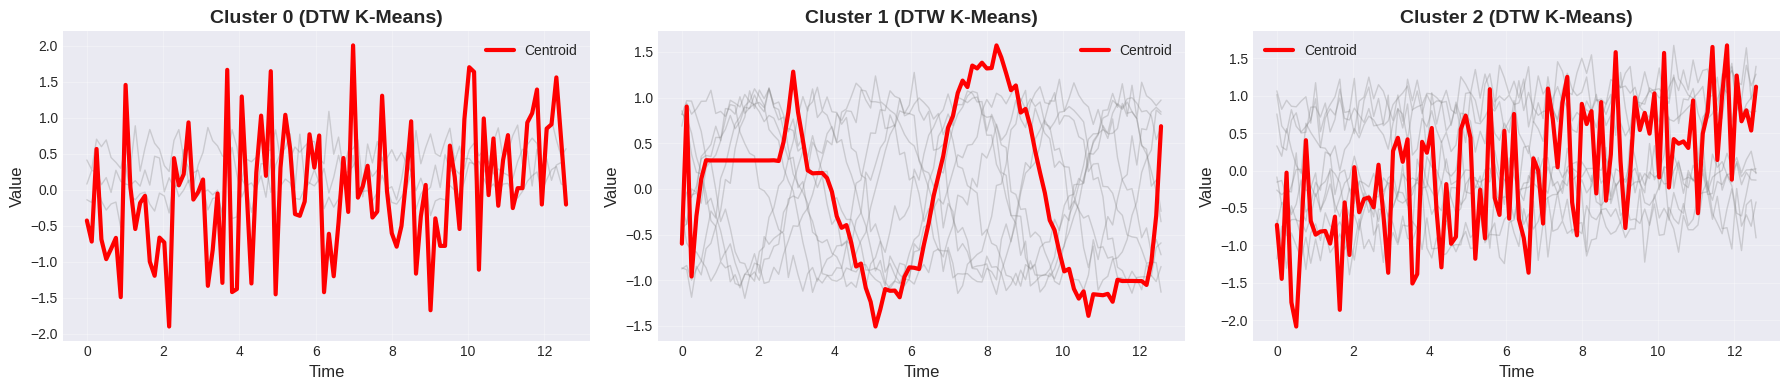

In [5]:
# Reshape for tslearn (samples, timesteps, features)
X_ts_reshaped = X_ts.reshape(-1, n_timesteps, 1)

# Scale time series
scaler_ts = TimeSeriesScalerMeanVariance()
X_ts_scaled = scaler_ts.fit_transform(X_ts_reshaped)

# Apply Time Series K-Means with DTW
ts_kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42, n_jobs=-1)
labels_tskmeans = ts_kmeans.fit_predict(X_ts_scaled)

# Calculate metrics (using flattened data for metrics)
X_ts_flat = X_ts_scaled.reshape(X_ts_scaled.shape[0], -1)
silhouette_tskmeans = silhouette_score(X_ts_flat, labels_tskmeans)
ari_tskmeans = adjusted_rand_score(y_true, labels_tskmeans)
db_tskmeans = davies_bouldin_score(X_ts_flat, labels_tskmeans)

print("TIME SERIES K-MEANS (DTW) RESULTS")
print("=" * 50)
print(f"Silhouette Score: {silhouette_tskmeans:.4f}")
print(f"Adjusted Rand Index: {ari_tskmeans:.4f}")
print(f"Davies-Bouldin Index: {db_tskmeans:.4f}")
print("=" * 50)

# Visualize cluster centroids
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for cluster_id in range(3):
    cluster_mask = labels_tskmeans == cluster_id
    cluster_samples = X_ts[cluster_mask][:10]

    for ts in cluster_samples:
        axes[cluster_id].plot(time, ts, alpha=0.3, linewidth=1, color='gray')

    # Plot centroid
    centroid = ts_kmeans.cluster_centers_[cluster_id].flatten()
    axes[cluster_id].plot(time, centroid, 'r-', linewidth=3, label='Centroid')

    axes[cluster_id].set_title(f'Cluster {cluster_id} (DTW K-Means)',
                              fontsize=14, fontweight='bold')
    axes[cluster_id].set_xlabel('Time', fontsize=12)
    axes[cluster_id].set_ylabel('Value', fontsize=12)
    axes[cluster_id].legend()
    axes[cluster_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Method 3: Using FFT Features


FFT FEATURES + K-MEANS RESULTS
Silhouette Score: 0.2092
Adjusted Rand Index: 0.5382
Davies-Bouldin Index: 1.7067


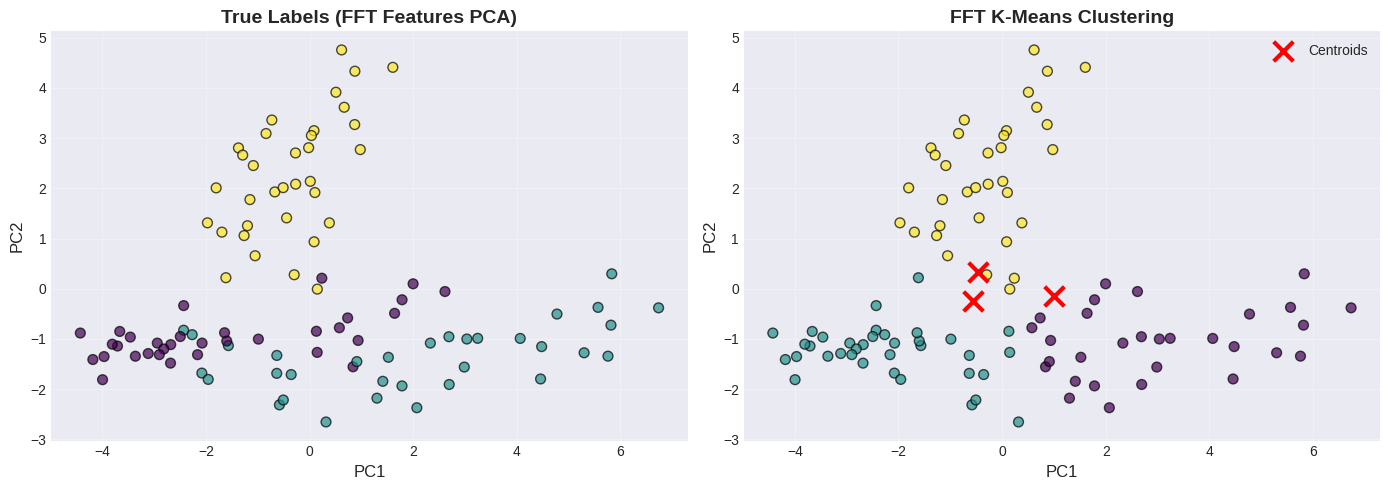

In [6]:
# Extract FFT features (frequency domain)
def extract_fft_features(ts_data, n_components=20):
    features = []
    for ts in ts_data:
        fft_vals = np.fft.fft(ts)
        # Take magnitude of first n_components
        fft_magnitude = np.abs(fft_vals[:n_components])
        features.append(fft_magnitude)
    return np.array(features)

# Extract FFT features
X_fft = extract_fft_features(X_ts, n_components=20)

# Standardize
scaler_fft = StandardScaler()
X_fft_scaled = scaler_fft.fit_transform(X_fft)

# Apply K-Means
kmeans_fft = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_fft = kmeans_fft.fit_predict(X_fft_scaled)

# Calculate metrics
silhouette_fft = silhouette_score(X_fft_scaled, labels_fft)
ari_fft = adjusted_rand_score(y_true, labels_fft)
db_fft = davies_bouldin_score(X_fft_scaled, labels_fft)

print("FFT FEATURES + K-MEANS RESULTS")
print("=" * 50)
print(f"Silhouette Score: {silhouette_fft:.4f}")
print(f"Adjusted Rand Index: {ari_fft:.4f}")
print(f"Davies-Bouldin Index: {db_fft:.4f}")
print("=" * 50)

# Visualize using PCA
pca_fft = PCA(n_components=2)
X_fft_pca = pca_fft.fit_transform(X_fft_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_fft_pca[:, 0], X_fft_pca[:, 1], c=y_true, cmap='viridis',
               s=50, alpha=0.7, edgecolors='k')
axes[0].set_title('True Labels (FFT Features PCA)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_fft_pca[:, 0], X_fft_pca[:, 1], c=labels_fft, cmap='viridis',
               s=50, alpha=0.7, edgecolors='k')
axes[1].scatter(kmeans_fft.cluster_centers_[:, 0], kmeans_fft.cluster_centers_[:, 1],
               c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[1].set_title('FFT K-Means Clustering', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Comparison of Methods


COMPARISON OF CLUSTERING METHODS
Method                              Silhouette   ARI          Davies-Bouldin 
----------------------------------------------------------------------
Statistical Features + K-Means      0.6145       0.4406       0.7163         
Time Series K-Means (DTW)           0.0305       0.5315       3.2179         
FFT Features + K-Means              0.2092       0.5382       1.7067         


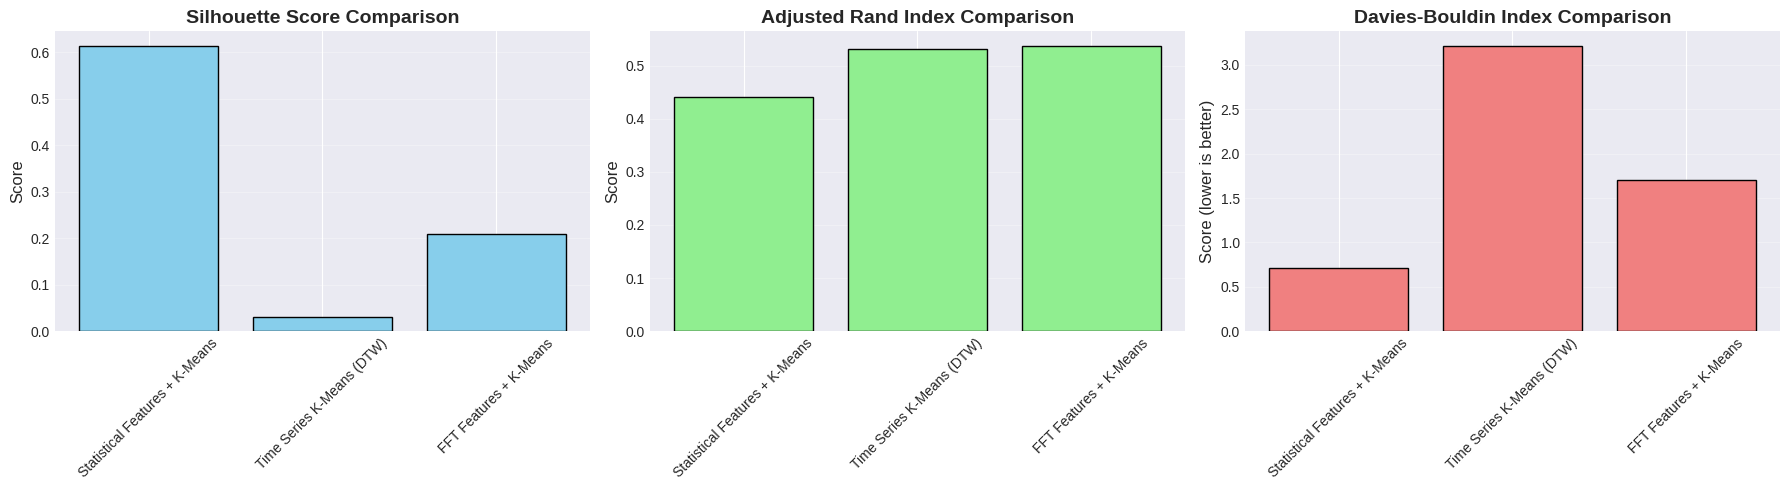

In [7]:
# Compare all methods
methods = {
    'Statistical Features + K-Means': {
        'silhouette': silhouette_kmeans,
        'ari': ari_kmeans,
        'db': db_kmeans
    },
    'Time Series K-Means (DTW)': {
        'silhouette': silhouette_tskmeans,
        'ari': ari_tskmeans,
        'db': db_tskmeans
    },
    'FFT Features + K-Means': {
        'silhouette': silhouette_fft,
        'ari': ari_fft,
        'db': db_fft
    }
}

print("=" * 70)
print("COMPARISON OF CLUSTERING METHODS")
print("=" * 70)
print(f"{'Method':<35} {'Silhouette':<12} {'ARI':<12} {'Davies-Bouldin':<15}")
print("-" * 70)
for method, metrics in methods.items():
    print(f"{method:<35} {metrics['silhouette']:<12.4f} {metrics['ari']:<12.4f} {metrics['db']:<15.4f}")
print("=" * 70)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

method_names = list(methods.keys())
silhouette_scores = [methods[m]['silhouette'] for m in method_names]
ari_scores = [methods[m]['ari'] for m in method_names]
db_scores = [methods[m]['db'] for m in method_names]

axes[0].bar(method_names, silhouette_scores, color='skyblue', edgecolor='black')
axes[0].set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(method_names, ari_scores, color='lightgreen', edgecolor='black')
axes[1].set_title('Adjusted Rand Index Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(method_names, db_scores, color='lightcoral', edgecolor='black')
axes[2].set_title('Davies-Bouldin Index Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Score (lower is better)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Summary

This notebook demonstrated:
1. Time series clustering using multiple approaches
2. Feature extraction methods (statistical, FFT)
3. Time Series K-Means with DTW distance
4. Comparison of different clustering methods
5. Evaluation using quality metrics

### Key Takeaways:
- Time series clustering requires specialized distance metrics (DTW)
- Feature extraction can simplify time series for traditional clustering
- FFT features capture frequency domain characteristics
- DTW-based clustering preserves temporal structure
- Different methods work better for different time series patterns
